In [46]:
# for data manipulation
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go # note that github wont be able to display these plots because they are interactive
# for some processing
import math
from datetime import datetime, timedelta

In [47]:
import sys
import os

class SuppressPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout  # Save the original stdout
        sys.stdout = open(os.devnull, 'w')  # Redirect stdout to null

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()  # Close the null file
        sys.stdout = self._original_stdout  # Restore original stdout

In [48]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.utils import resample

In [49]:
folder = "kaggle/input/"
df = pd.read_csv(folder + "train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CustomerID                     7290 non-null   object 
 1   State                          7290 non-null   object 
 2   Customer Lifetime Value        7290 non-null   float64
 3   Response                       7290 non-null   object 
 4   Coverage                       7290 non-null   object 
 5   Coverage Index                 7290 non-null   int64  
 6   Education                      7290 non-null   object 
 7   Education Index                7290 non-null   int64  
 8   Effective To Date              7290 non-null   object 
 9   Employment Status              7290 non-null   object 
 10  Employment Status Index        7290 non-null   int64  
 11  Gender                         7290 non-null   object 
 12  Income                         7290 non-null   i

In [50]:
# drop the unnecessary columns
df_train = df.drop(columns = ["CustomerID", "Coverage", "Education", "Employment Status", "Marital Status", "Policy Type", "Policy", "Sales Channel", "Vehicle Size"])
df_train.info()
df_train["Claim over 1k"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7290 entries, 0 to 7289
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          7290 non-null   object 
 1   Customer Lifetime Value        7290 non-null   float64
 2   Response                       7290 non-null   object 
 3   Coverage Index                 7290 non-null   int64  
 4   Education Index                7290 non-null   int64  
 5   Effective To Date              7290 non-null   object 
 6   Employment Status Index        7290 non-null   int64  
 7   Gender                         7290 non-null   object 
 8   Income                         7290 non-null   int64  
 9   Marital Status Index           7290 non-null   int64  
 10  Months Since Last Claim        7290 non-null   int64  
 11  Months Since Policy Inception  7290 non-null   int64  
 12  Number of Open Complaints      7290 non-null   i

Claim over 1k
0    6458
1     832
Name: count, dtype: int64

In [51]:
from plotly.subplots import make_subplots

def relation_to_claim_over_1k(df):
  plt.figure(figsize=(30, 80))
  numerical_cols = df.columns.tolist()
  not_include = ["Customer Lifetime Value", "Income", "Claim over 1k"]
  numerical_cols = [col for col in numerical_cols if col not in not_include]
  
  number_of_rows = math.ceil(len(numerical_cols) / 2)
  fig = make_subplots(rows = number_of_rows, cols=2, subplot_titles=numerical_cols, vertical_spacing=0.01, horizontal_spacing=0.05)
  for idx, col in enumerate(numerical_cols):
    df_count = df.groupby([col, "Claim over 1k"]).size().reset_index(name='count')
    unique_val = df_count[col].unique()
    i, j = (idx // 2) + 1, (idx % 2) + 1
    for val in unique_val:
      df_cur = df_count[df_count[col] == val]
      fig.add_trace(
        go.Bar(
          x = df_cur["Claim over 1k"],
          y = df_cur["count"],
          name = f"{val}"
        ),
        row=i, col=j
      )
  fig.update_layout(
      height=300 * number_of_rows,  # Adjust figure height dynamically based on the number of rows
      showlegend=False,
      title_text="How Each Column Affects 'Claim over 1k'"
  )
  # Show the figure with all subplots
  fig.show()

In [52]:
def numeric_info(df, col):
  print(f"Min of {col}: ", df[col].min())
  print(f"Max of {col}: ", df[col].max())
  print(f"Mean of {col}: ", df[col].mean())
  print(f"Mendian of {col}: ", df[col].median())
  print(f"Std of {col}: ", df[col].std())

In [53]:
def binning(df, col, size):
  df[col + "_bin"] = pd.qcut(df[col], q=size, labels=False, duplicates="drop")

def convert(n, range_max, range_min):
  return n / (range_max - range_min)

def pre_process(df):
  # State
  unique_states = df["State"].unique()
  dict_states = {}
  for i in range(len(unique_states)):
    dict_states[unique_states[i]] = i
  df["State"] = df["State"].apply(lambda x: dict_states[x])
  
  # Response
  # note that resonse should be either yes or no
  df["Response"] = df["Response"].apply(lambda x: 1 if x == "Yes" else 0)

  # Effective To Date
  df["Effective To Date"] = pd.to_datetime(df["Effective To Date"])
  df["Effective To Season"] = (df["Effective To Date"].dt.month - 1) // 3 # split into 4 seasons
  df.drop("Effective To Date", axis=1, inplace=True)

  # Months Since Last Claim, Months Since Last Inception
  binning(df, "Months Since Last Claim", 5)
  binning(df, "Months Since Policy Inception", 5)

  # Gender
  df["Gender"] = df["Gender"].apply(lambda x: 1 if x == "M" else 0)

  # CLV
  binning(df, "Customer Lifetime Value", 80)
  # Categorize CLV
  clv_bins = [df['Customer Lifetime Value'].min(), 5000, 10000, df['Customer Lifetime Value'].max()]
  clv_labels = [0, 1, 2]
  df['CLV_Category'] = pd.cut(df['Customer Lifetime Value'], bins=clv_bins, labels=clv_labels, include_lowest=True)
  
  # Income
  binning(df, "Income", 60)
  # Categorize Income
  income_bins = [df['Income'].min(), 40000, 80000, df['Income'].max()]
  income_labels = [0, 1, 2]
  df['Income_Category'] = pd.cut(df['Income'], bins=income_bins, labels=income_labels, include_lowest=True)

  # New col: CLV per number of policies and months since policy inception
  df["Money Spent per Policy"] = df["Customer Lifetime Value"] / ((df["Coverage Index"] + 1) * (df["Number of Policies"] + 1))

  binning(df, "Money Spent per Policy", 80)

  # New col: Accident Likelihood
  max_education_index = df["Education Index"].max()
  min_education_index = df["Education Index"].min()
  max_income_bin = df["Income_bin"].max()
  min_income_bin = df["Income_bin"].min()
  max_marital_status_index = df["Marital Status Index"].max()
  min_marital_status_index = df["Marital Status Index"].min()
  df["Accident Likelihood"] = np.exp( 4 * convert(max_education_index - df["Education Index"], max_education_index, min_education_index) \
    + 3 * convert(max_income_bin - df["Income_bin"], max_income_bin, min_income_bin) \
    + 3 * (df["Marital Status Index"].apply(lambda x: max_marital_status_index if x == 0 else 0)))

  binning(df, "Accident Likelihood", 5)

  # New col: Claim over 1k Likelihood based on State and Gender
  group_over = ["State", "Gender", "Employment Status Index", "Income_bin"]
  likelihood_df = df.groupby(group_over)["Accident Likelihood"].mean().reset_index()
  likelihood_df.rename(columns={"Accident Likelihood": "Location Based Likelihood"}, inplace=True)
  # Merge the likelihood values back to the original dataframe
  df = pd.merge(df, likelihood_df, on=group_over, how="left")
  
  binning(df, "Location Based Likelihood", 15)

  # New col: may relate to the Customer Lifetime Value
  df["Insurance"] = np.exp(convert(df["Number of Policies"], df["Number of Policies"].max(), df["Number of Policies"].min()) \
    + convert(df["Coverage Index"], df["Coverage Index"].max(), df["Coverage Index"].min()) \
    + convert(df["Number of Policies"], df["Number of Policies"].max(), df["Number of Policies"].min()) * convert(df["Coverage Index"], df["Coverage Index"].max(), df["Coverage Index"].min())
    # + 0.5 * convert(df["Policy Index"], df["Policy Index"].max(), df["Policy Index"].min()) \
    # + 0.5 * convert(df["Sales Channel Index"], df["Sales Channel Index"].max(), df["Sales Channel Index"].min()) \
    # + 0.5 * convert(df["Renew Offer Type"], df["Renew Offer Type"].max(), df["Renew Offer Type"].min())
    # + 0.5 * convert(df["Months Since Policy Inception"], df["Months Since Policy Inception"].max(), df["Months Since Policy Inception"].min())
    )

  binning(df, "Insurance", 60)

  # New col: may relate to Cusomter Lifetime Value
  df["Customer Interaction"] = np.exp(convert(df["Response"], df["Response"].max(), df["Response"].min()) \
    + convert(df["Number of Open Complaints"], df["Number of Open Complaints"].max(), df["Number of Open Complaints"].min()))
  
  binning(df, "Customer Interaction", 30)

  # New col: may realte to Accident Likelihood
  group_datetime = ["Months Since Last Claim", "Effective To Season"]
  datetime_df = df.groupby(group_datetime)["Accident Likelihood"].mean().reset_index()
  datetime_df.rename(columns={"Accident Likelihood": "Date Time"}, inplace=True)
  # Merge
  df = pd.merge(df, datetime_df, on=group_datetime, how="left")

  binning(df, "Date Time", 30)

  # cols_to_remove = ["Customer Lifetime Value", "Accident Likelihood", "Income", "Insurance", "Location Based Likelihood", "Date Time", \
  #   "Months Since Policy Inception", "Vehicle Size Index", "Gender", "Effective To Season", "Policy Index", "Customer Interaction", \
  #   "Education Index", "Months Since Last Claim", "Renew Offer Type", "State", "Number of Open Complaints", "Sales Channel Index", "Response", "Policy Type Index"
  #   ]
  # df.drop(columns=cols_to_remove, axis=1, inplace=True)
  # cols_to_use = ["Customer Lifetime Value", "Money Spent per Policy", "Accident Likelihood", "Number of Policies", "Income", "Coverage Index", \
  #   "Employment Status Index", "Insurance", "Marital Status Index", "Location Based Likelihood", "Claim over 1k", \
  #   "Date Time", "Education Index", "Months Since Last Claim", "Vehicle Size Index", "Gender", "Months Since Policy Inception"
  #   ]
  cols_to_use = ["Customer Lifetime Value", "Money Spent per Policy_bin", "Accident Likelihood_bin", "Number of Policies", "Income_bin", "Coverage Index", \
    "Employment Status Index", "Insurance_bin", "Marital Status Index", "Location Based Likelihood_bin", "Claim over 1k", \
    "Date Time", "Months Since Last Claim", "Gender", "Months Since Policy Inception", \
    "CLV_Category", "Income_Category"
    ]
  return df[cols_to_use]

In [54]:
df_process = pre_process(df_train.copy())

In [55]:
relation_to_claim_over_1k(df_process)

/tmp/ipykernel_63878/4146269032.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipykernel_63878/4146269032.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 3000x8000 with 0 Axes>

(1458, 16, 2)


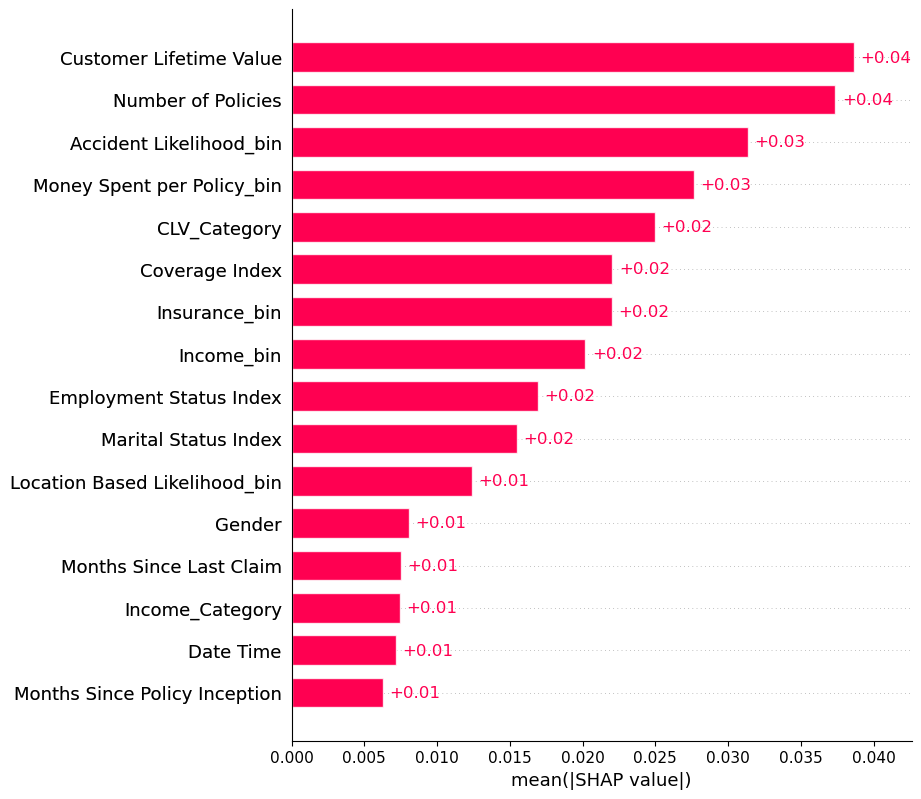

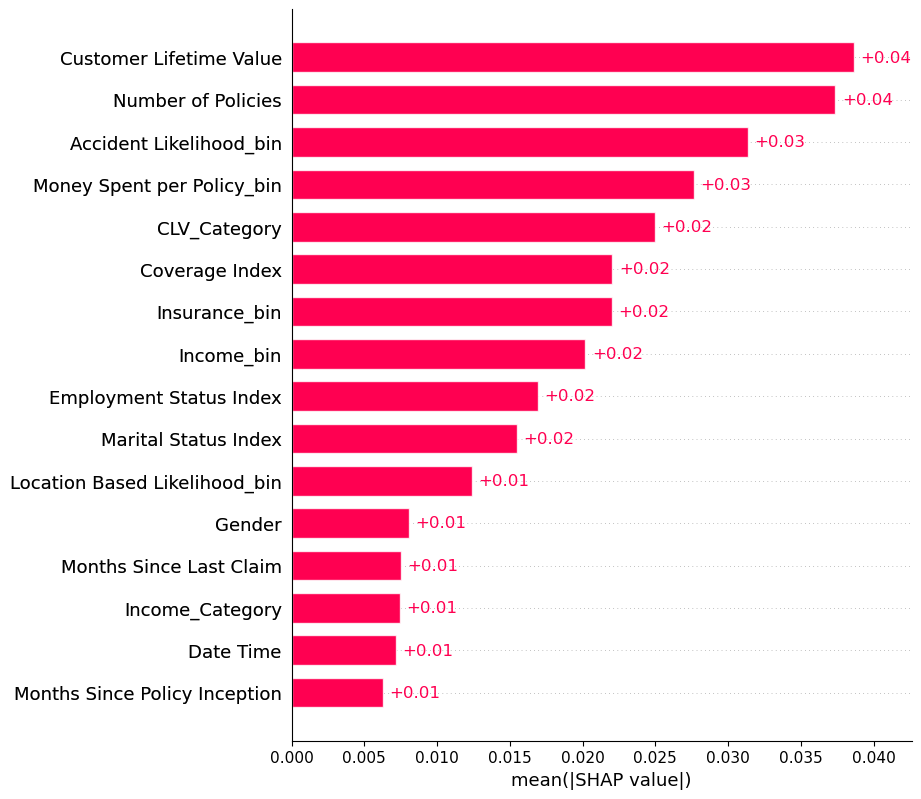

(1458, 16) (1458, 16)


In [56]:
import shap

def shap_plot(df_train):
  X = df_train.drop("Claim over 1k", axis=1)
  y = df_train["Claim over 1k"]
  test_size = 0.2
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)

  # Train a Random Forest model
  model = RandomForestClassifier()
  model.fit(X_train, y_train)
  # Initialize the SHAP explainer
  explainer = shap.Explainer(model, feature_names=X.columns)
  
  # Calculate SHAP values for the test dataset
  shap_values = explainer(X_test)

  print(shap_values.shape)
  shap_values_0 = shap_values[:, :, 0]
  shap_values_1 = shap_values[:, :, 1]
  shap.plots.bar(shap_values_0, max_display=400)
  shap.plots.bar(shap_values_1, max_display=400)
  print(shap_values_0.shape, shap_values_1.shape)
  return shap_values
shap_values = shap_plot(df_process)

In [57]:
def test_monitor(model, X, y):
  threshold = 0.5
  # Predict the test set
  y_proba = model.predict_proba(X)
  y_pred = (y_proba[:, 1] >= threshold).astype(int)
  # Evaluate the model
  accuracy = accuracy_score(y, y_pred)
  conf_matrix = confusion_matrix(y, y_pred).T
  class_report = classification_report(y, y_pred)

  # Calculate accuracy and F1 score
  print(f"Accuracy: {accuracy}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print("Classification Report:")
  print(class_report)
  f1 = f1_score(y, y_pred)
  print(f"f1 score: ${f1}")
  
  #            Actual
  #             0   1
  # Predict 0   TP  FP
  #         1   FN  TN
  # Evaluate the model
  tp, fp, fn, tn = conf_matrix.ravel()
  # Calculate sensitivity and specificity
  sensitivity = tp / (tp + fn)  # True Positive Rate
  specificity = tn / (tn + fp)  # True Negative Rate

  print("Sensitivity (Recall):", sensitivity)
  print("Specificity:", specificity)

  return accuracy, sensitivity, specificity

In [58]:
def normalize(X, scaler):
  return scaler.fit_transform(X)

def get_train_params(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 42)
  return X_train, X_test, y_train, y_test

In [72]:
def run_random_forest_normal(X_train, y_train):
  # Initialize the Random Forest Classifier
  rf_classifier = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=30, min_samples_leaf=2, min_samples_split=5, bootstrap=False)

  # Train the model on the training data
  # Note that random forest is a decision tree (if-else statment on each node), so the data does not have to be scaled
  rf_classifier.fit(X_train, y_train)
  return rf_classifier

def random_forest(df_train):
  df_train.value_counts()
  # Get the params
  X = df_train.drop("Claim over 1k", axis=1)
  y = df_train["Claim over 1k"]
  X_train_scaled, X_test_scaled, y_train, y_test = get_train_params(X, y, 0.2)

  rf_classifier = run_random_forest_normal(X_train_scaled, y_train)
  accuracy_from_train, sensitivity_from_train, specificity_from_train = test_monitor(rf_classifier, X_test_scaled, y_test)
  
  return accuracy_from_train, sensitivity_from_train, specificity_from_train

In [73]:
def run_iteration_simple(df_train, times, cols=[]):
  accuracy, sensitivity, specificity = 0, 0, 0
  df_shorten_train = df_train.drop(columns=cols, axis=1)
  for _ in range(times):
    with SuppressPrints():
      accuracy_get, sensitivity_get, specificity_get = random_forest(df_shorten_train)
      accuracy += float(accuracy_get)
      sensitivity += float(sensitivity_get)
      specificity += float(specificity_get)
  print(f"Average over {times} runs: ", accuracy / times, sensitivity / times, specificity / times)

In [74]:
random_forest(df_process) # test with no oversample

Accuracy: 0.9307270233196159
Confusion Matrix:
[[1276   77]
 [  24   81]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1300
           1       0.77      0.51      0.62       158

    accuracy                           0.93      1458
   macro avg       0.86      0.75      0.79      1458
weighted avg       0.92      0.93      0.92      1458

f1 score: $0.6159695817490495
Sensitivity (Recall): 0.9815384615384616
Specificity: 0.5126582278481012


(0.9307270233196159, 0.9815384615384616, 0.5126582278481012)

In [76]:
run_iteration_simple(df_process, 20)

Average over 20 runs:  0.9312414266117969 0.9818846153846155 0.5145569620253164


In [65]:
def hyper_tune_random_forest(df_train):
  X = df_train.drop("Claim over 1k", axis=1)
  y = df_train["Claim over 1k"]
  X_train_scaled, X_test_scaled, y_train, y_test = get_train_params(X, y, 0.2)
  # Step 2: Define the model
  rf_classifier = RandomForestClassifier(random_state=42)

  # Step 3: Specify hyperparameters to tune
  param_grid = {
    'n_estimators': [100, 200, 250],          # Number of trees
    'max_depth': [10, 20, 30],             # Maximum depth of the trees
    'min_samples_split': [5, 10],         # Minimum samples to split an internal node
    'min_samples_leaf': [2, 5, 10],          # Minimum samples at a leaf node
    'bootstrap': [False, True],
    'class_weight': [None, 'balanced']
  }

  # Step 4: Set up GridSearchCV
  grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid,
                 cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

  # Step 5: Fit the model
  grid_search.fit(X_train_scaled, y_train)

  # Step 6: Evaluate the best model
  best_model = grid_search.best_estimator_
  
  return best_model
# best_model = hyper_tune_random_forest(df_process)
# print(best_model)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.1s
[CV] END bootstrap=False, class_weight=None, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=2